 # Quick comparison of PCN and BioPCN on Mediamill

In [1]:
import os.path as osp

import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch
import time

from cpcn import *
from cpcn.graph import *

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# get train and validation loaders for Mediamill
path = osp.join("data", "mediamill")
batch_size = 100
dataset = load_csv(
    osp.join(path, "view1.csv"),
    osp.join(path, "view2.csv"),
    n_validation=1000,
    batch_size=batch_size,
    device=device,
)

 ## Train PCN

In [3]:
one_batch = next(iter(dataset["train"]))
n_in = one_batch[0].shape[1]
n_out = one_batch[1].shape[1]
dims = [n_in, 50, 5, n_out]
n_batches = 2000
z_it = 50
z_lr = 0.062

t0 = time.time()
torch.manual_seed(123)

net0 = PCNetwork(
    dims,
    activation="none",
    z_lr=z_lr,
    z_it=z_it,
    variances=1.0,
    constrained=False,
    bias=False,
)
net = PCWrapper(net0, "linear").to(device)
optimizer = torch.optim.SGD(net.pc_net.parameters(), lr=0.01)
predictor_optimizer = torch.optim.Adam(net.predictor.parameters())
lr_power = 1.0
lr_rate = 4e-4
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda batch: 1 / (1 + lr_rate * batch ** lr_power)
)
trainer = Trainer(dataset["train"], invalid_action="warn+stop")
trainer.metrics["accuracy"] = dot_accuracy
for batch in tqdmw(trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(net)
        batch.weight.report("W", net.pc_net.W)

    ns = batch.feed(net, latent_profile=True)
    batch.latent.report_batch("z", ns.fast.z)
    if batch.count(4):
        batch.fast.report_batch("z", [_.transpose(0, 1) for _ in ns.fast.profile.z])

    optimizer.step()
    predictor_optimizer.step()
    scheduler.step()

results = trainer.history
print(f"Training PCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training PCN took 62.8 seconds.


 ### Show PCN learning curves

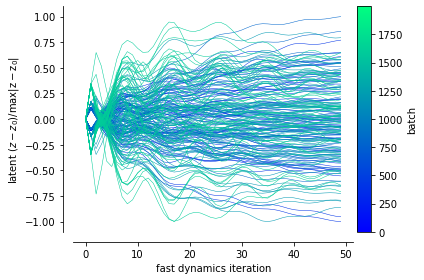

In [4]:
with dv.FigureManager() as (_, ax):
    show_latent_convergence(results.fast, ax=ax)

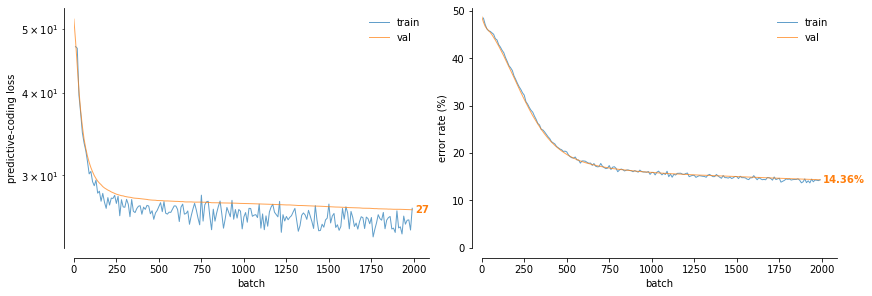

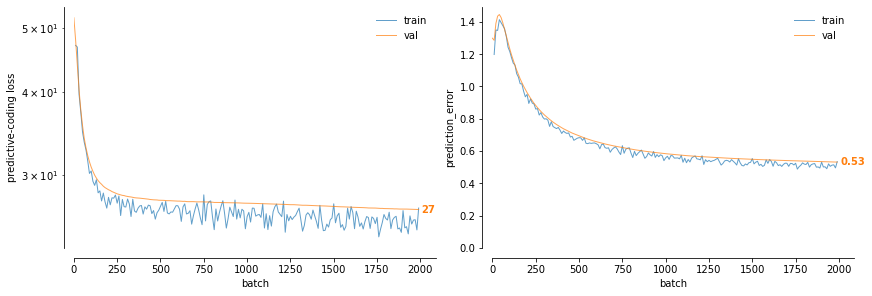

In [5]:
_ = show_learning_curves(results)
_ = show_learning_curves(results, var_names=("pc_loss", "prediction_error"))

 ### Show covariance diagnostics

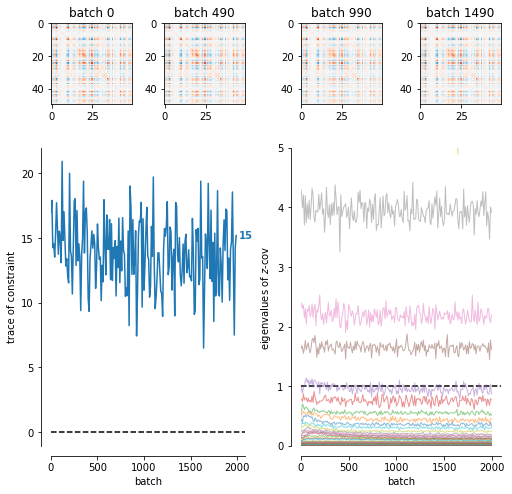

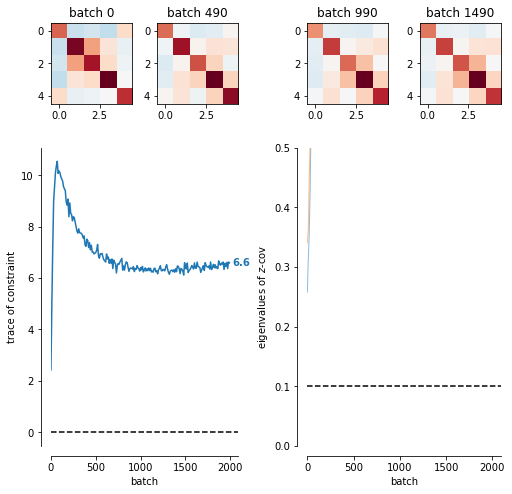

In [6]:
cons_diag = get_constraint_diagnostics(results.latent, rho=[1.0, 1.0, 0.1, 1.0])
_ = show_constraint_diagnostics(cons_diag, layer=1, rho=1.0)
_ = show_constraint_diagnostics(cons_diag, layer=2, rho=0.1)

 ## Train BioPCN

In [7]:
z_it = 50
z_lr = 0.13
rho = [0.2, 0.02]

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net0 = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)

biopcn_net = PCWrapper(biopcn_net0, "linear").to(device)
biopcn_optimizer = multi_lr(
    torch.optim.SGD,
    biopcn_net.pc_net.parameter_groups(),
    lr_factors={"Q": 3.5},
    lr=0.003,
)
biopcn_predictor_optimizer = torch.optim.Adam(biopcn_net.predictor.parameters())
lr_power = 1.0
lr_rate = 2e-4
biopcn_scheduler = torch.optim.lr_scheduler.LambdaLR(
    biopcn_optimizer, lr_lambda=lambda batch: 1 / (1 + lr_rate * batch ** lr_power)
)
biopcn_trainer = Trainer(dataset["train"], invalid_action="warn+stop")
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)
        batch.weight.report(
            {
                "W_a": biopcn_net.pc_net.W_a,
                "W_b": biopcn_net.pc_net.W_b,
                "Q": biopcn_net.pc_net.Q,
            }
        )

    ns = batch.feed(biopcn_net, latent_profile=True)
    batch.latent.report_batch("z", ns.fast.z)
    if batch.count(4):
        batch.fast.report_batch("z", [_.transpose(0, 1) for _ in ns.fast.profile.z])

    biopcn_optimizer.step()
    biopcn_predictor_optimizer.step()
    biopcn_scheduler.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training BioPCN took 81.6 seconds.


 ### Show BioPCN learning curves

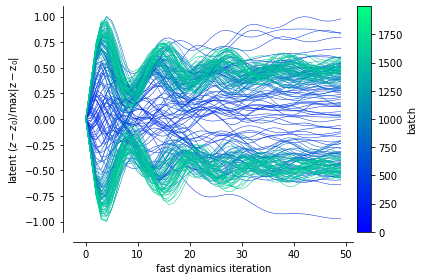

In [8]:
with dv.FigureManager() as (_, ax):
    show_latent_convergence(biopcn_results.fast, ax=ax)

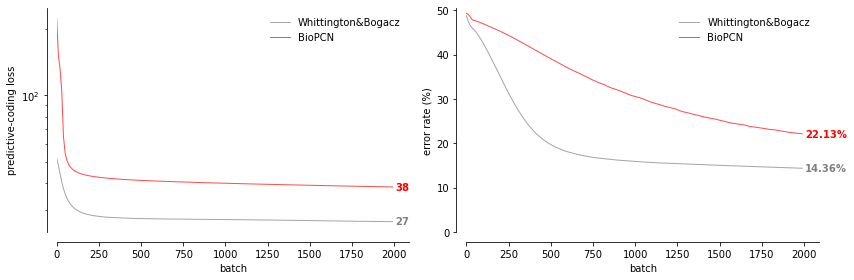

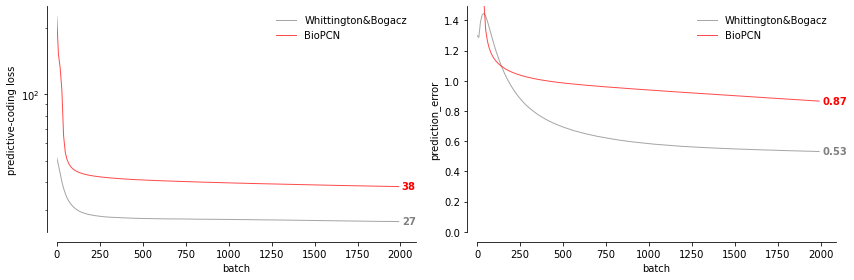

In [9]:
with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        axs=axs,
    )

with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        var_names=("pc_loss", "prediction_error"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        var_names=("pc_loss", "prediction_error"),
        axs=axs,
    )

 ### Show covariance diagnostics

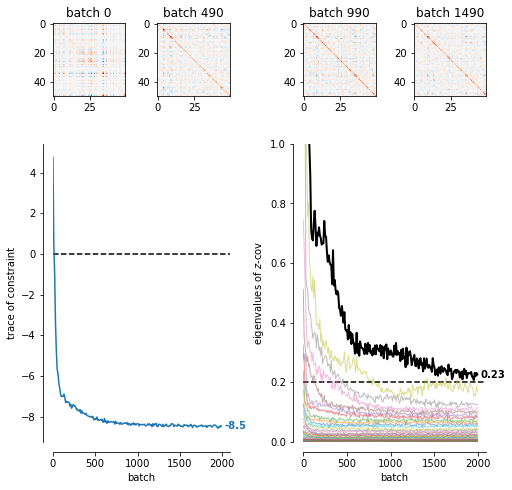

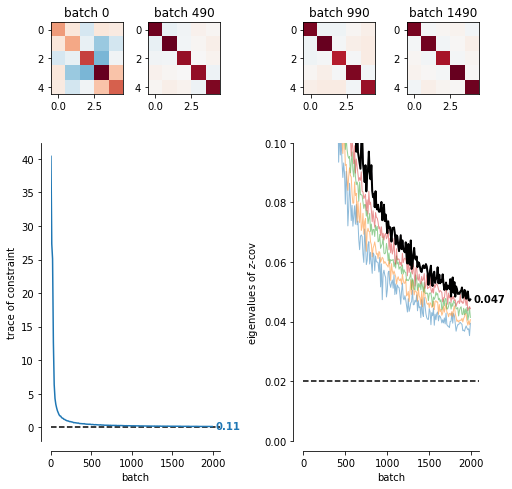

In [10]:
biopcn_cons_diag = get_constraint_diagnostics(
    biopcn_results.latent, rho=[1] + list(biopcn_net0.rho) + [1]
)
_ = show_constraint_diagnostics(biopcn_cons_diag, layer=1, rho=biopcn_net0.rho[0])
_ = show_constraint_diagnostics(biopcn_cons_diag, layer=2, rho=biopcn_net0.rho[1])